DSA_features 데이터셋을 가지고 AE 수행

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
df = pd.read_csv('C:/dataset/DSA_features.csv')

In [7]:
# 숫자형 컬럼만 선택 (activity 제외)
numeric_columns = df.select_dtypes(include=[np.number]).columns

# normal과 abnormal 데이터 분리
normal_data = df[df['activity'].isin(['lyingRight', 'lyingBack'])][numeric_columns]
abnormal_data = df[df['activity'] == 'jumping'][numeric_columns]

print("Normal data shape:", normal_data.shape)
print("Abnormal data shape:", abnormal_data.shape)

# 데이터가 비어있는지 확인
if len(normal_data) == 0 or len(abnormal_data) == 0:
    raise ValueError("No data found for either normal or abnormal cases")

# 데이터 스케일링
scaler = StandardScaler()
normal_scaled = scaler.fit_transform(normal_data)
abnormal_scaled = scaler.transform(abnormal_data)

Normal data shape: (480, 270)
Abnormal data shape: (480, 270)


In [8]:
# 훈련 데이터 준비 (normal 데이터의 80%)
train_size = int(len(normal_scaled) * 0.8)
X_train = normal_scaled[:train_size]

# 테스트 데이터 준비 (나머지 normal + 모든 abnormal)
X_test = np.vstack([normal_scaled[train_size:], abnormal_scaled])
y_test = np.hstack([np.zeros(len(normal_scaled[train_size:])), 
                    np.ones(len(abnormal_scaled))])

In [9]:
# 3. Autoencoder 모델 구축
input_dim = X_train.shape[1]
encoding_dim = min(32, input_dim)  # 입력 차원보다 작게 설정

# 더 깊은 autoencoder 구조
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 구조 출력
print("\nModel Summary:")
autoencoder.summary()


Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 270)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 270)                 │          17,550 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,086 (152.68 KB)

 Trainable params: 39,086 (152.68 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 훈련 (early stopping 추가)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Reconstruction error 계산
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# 5. Threshold 설정 및 분류
# normal 데이터의 reconstruction error의 95퍼센타일을 threshold로 사용
normal_reconstruction_error = np.mean(
    np.power(
        autoencoder.predict(normal_scaled[train_size:]) - normal_scaled[train_size:],
        2
    ),
    axis=1
)
threshold = np.percentile(normal_reconstruction_error, 95)
predictions = (mse > threshold).astype(int)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.4288 - val_loss: 1.4739
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0951 - val_loss: 1.4293
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9586 - val_loss: 1.3570
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4398 - val_loss: 1.2970
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8788 - val_loss: 1.2746
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6945 - val_loss: 1.2652
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8642 - val_loss: 1.2587
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8062 - val_loss: 1.2513
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9532 - val_loss: 1.2433
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7735 - val_loss: 1.2396
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8696 - val_loss: 1.2350
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.

In [11]:
# 6. 결과 출력
accuracy = accuracy_score(y_test, predictions)
print("\nResults:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Threshold value: {threshold:.4f}')
print(f'Number of normal samples in test: {len(abnormal_scaled)}')


Results:
Accuracy: 0.9913
Threshold value: 0.8255
Number of normal samples in test: 480


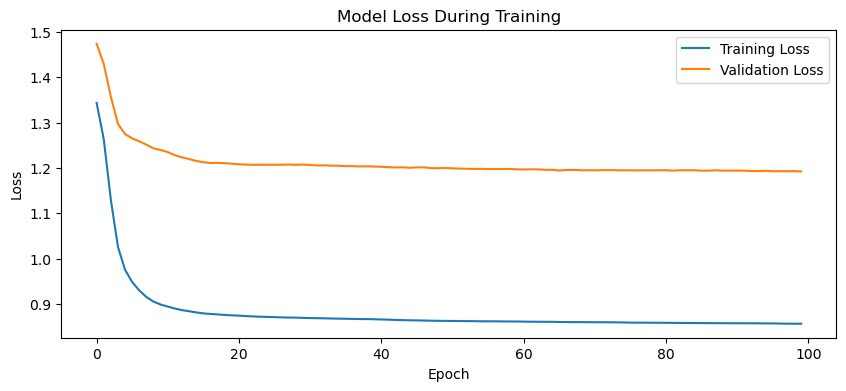

In [12]:
# 학습 곡선 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

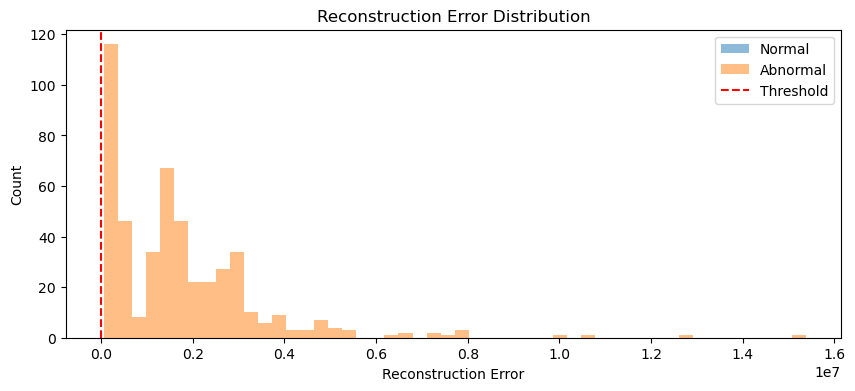

In [13]:
# Reconstruction Error 분포 시각화
plt.figure(figsize=(10, 4))
plt.hist(normal_reconstruction_error, bins=50, alpha=0.5, label='Normal')
plt.hist(mse[len(normal_scaled[train_size:]):], bins=50, alpha=0.5, label='Abnormal')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()